## Importing Libraries

In [1]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import timedelta
import seaborn as sns
%matplotlib inline

## Defining Functions

In [2]:
db = "chinook.db"

In [3]:
def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql(q, conn)

In [4]:
def run_command(c):
    with sql.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view')"   
    return run_query(q)
    

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Question 1 
### Which genres sell the most tracks in the USA?

#### Design Query:

In [7]:
query_america_genre_count = '''
     WITH usa_transactions AS
           (
           SELECT 
             il.track_id, 
             c.country 
             FROM invoice_line il
                INNER JOIN invoice i 
                ON il.invoice_id = i.invoice_id
                INNER JOIN customer c
                ON i.customer_id = c.customer_id
            WHERE c.country = "USA"
             )
        SELECT g.name genre, 
        COUNT(u.track_id) tracks_sold, 
        CAST(COUNT(u.track_id) AS FLOAT) / 
        (
        SELECT COUNT(*) from usa_transactions
        ) percentage_sold
        
        FROM genre g
             INNER JOIN track t
             ON g.genre_id = t.genre_id
             INNER JOIN usa_transactions u
             ON t.track_id = u.track_id
        GROUP BY genre
        ORDER BY 2 DESC
        LIMIT 10
     '''

#### Query Output:

In [8]:
america_df = run_query(query_america_genre_count)
america_df

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


#### Plot Results:

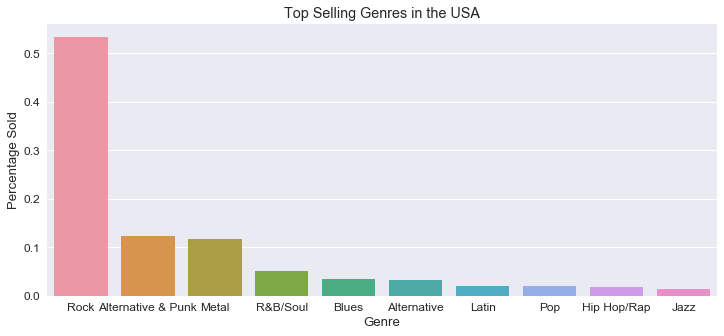

In [9]:
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
sns.barplot(x= america_df["genre"] , 
            y = america_df["percentage_sold"])
plt.title('Top Selling Genres in the USA')
plt.ylabel('Percentage Sold')
plt.xlabel('Genre')
plt.show()

#### Q1 Findings:

From the Graph it is clear that genres such as:
 - Rock
 - Alternative & Punk
 - Metal
 
Are sold the most in USA. Indeed they make up for 76% of the the total sells in America. 

## Question 2
### Find the total dollar amount of sales assigned to each "sales support agent" within the company

#### Design Query

In [10]:
query_emp_perf = ''' 
        SELECT 
        e.first_name || " " || e.last_name employee_name,
        hire_date,
        COUNT(i.total) total_sales,
        SUM(i.total) sales_$
        FROM employee e
              LEFT JOIN customer c
              ON e.employee_id = c.support_rep_id
              LEFT JOIN invoice i
              ON c.customer_id = i.customer_id
        WHERE title = "Sales Support Agent"
        GROUP BY employee_name
'''

#### Query Output:

In [11]:
employee_df = run_query(query_emp_perf)
employee_df

,employee_name,hire_date,total_sales,sales_$
0,Jane Peacock,2017-04-01 00:00:00,212,1731.51
1,Margaret Park,2017-05-03 00:00:00,214,1584.00
2,Steve Johnson,2017-10-17 00:00:00,188,1393.92


#### Plot Output:

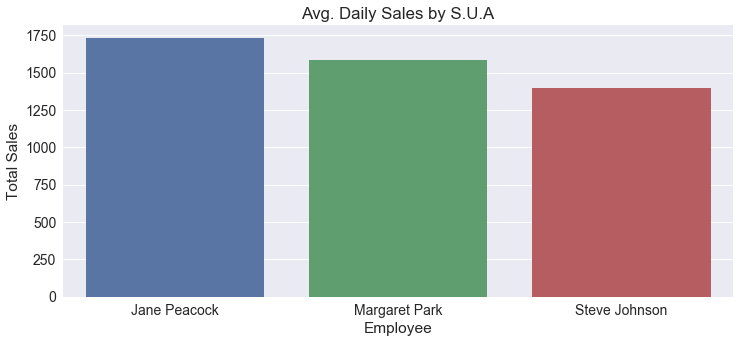

In [12]:
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 5))
sns.barplot( x= employee_df["employee_name"] , 
            y = employee_df["sales_$"])
plt.title('Avg. Daily Sales by S.U.A')
plt.ylabel('Total Sales')
plt.xlabel('Employee')
plt.show()

#### Q2 Findings:

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.
In order to better asses whether the performance is equal across sales agents we will analyse their daily performance in dollars since hire_date 

#### Q2 Further examination:

In [17]:
date_format = "%Y-%m-%d"
employee_df["hire_date"] = pd.to_datetime(employee_df["hire_date"])
b = datetime.datetime.today().strftime(date_format)
today = pd.to_datetime(b)

employee_df["days_since_hire"] = today - employee_df["hire_date"]
employee_df["avg_daily_sales"] = employee_df["total_sales"]/employee_df["days_since_hire"].astype('timedelta64[D]')
employee_df

,employee_name,hire_date,total_sales,sales_$,days_since_hire,avg_daily_sales
0,Jane Peacock,2017-04-01,212,1731.51,680 days,0.311765
1,Margaret Park,2017-05-03,214,1584.00,648 days,0.330247
2,Steve Johnson,2017-10-17,188,1393.92,481 days,0.390852


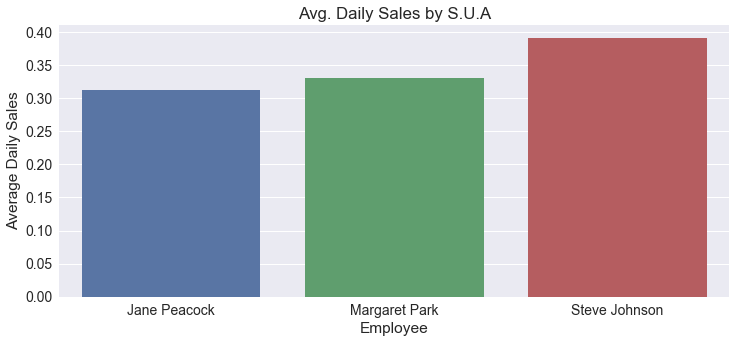

In [18]:
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 5))
sns.barplot( x= employee_df["employee_name"] , 
            y = employee_df["avg_daily_sales"])
plt.title('Avg. Daily Sales by S.U.A')
plt.ylabel('Average Daily Sales')
plt.xlabel('Employee')
plt.show()

We note that the ranking of the Top Sales Support Agent have reversed if measured by their daily average instead of their total sales. 

## Question 3
### For each country calculate:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

#### Design Query:

In [19]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''


#### Output:

In [20]:
country_sales_df = run_query(sales_by_country)
country_sales_df

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


#### Plot Output:

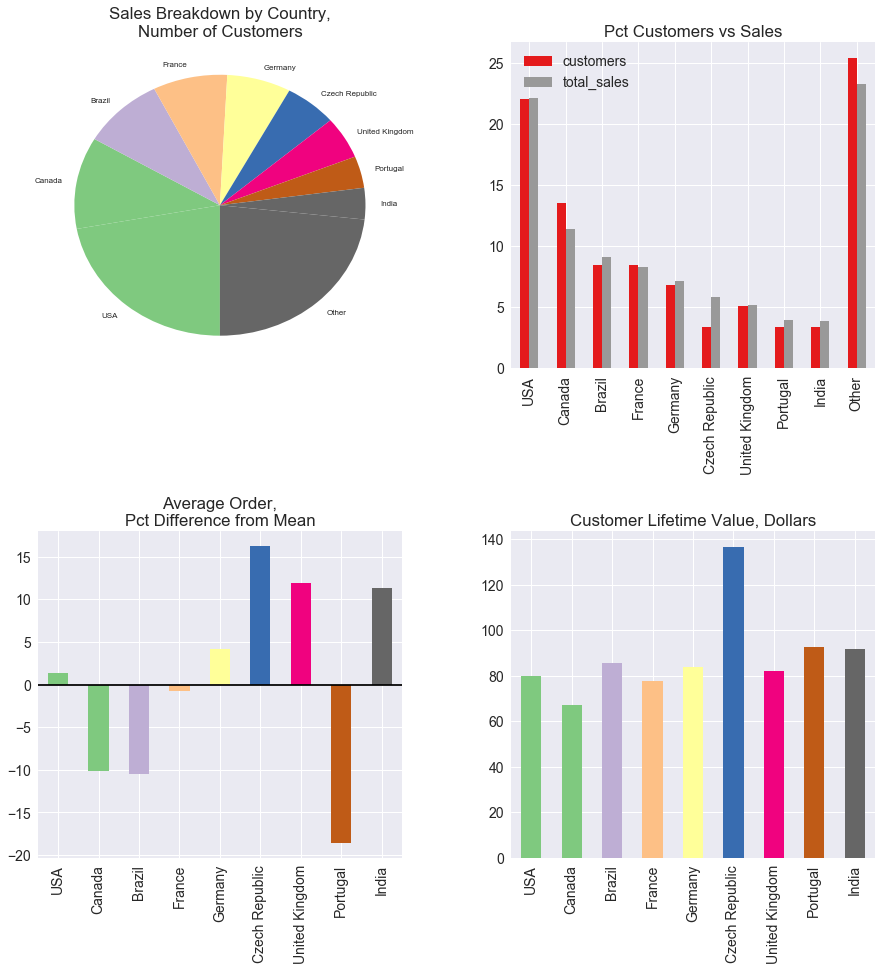

In [27]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)

ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)

ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Question 4
### Categorizing each invoice as either an album purchase or not, and calculating the following summary statistics:
- Number of invoices
- Percentage of invoices

In [296]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
